# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together. This is from 22-23 season, feel free to update to 2023-24 season if you want.
# Data Sources:

https://www.basketball-reference.com/leagues/NBA_2024_totals.html # reference for performance data
https://www.basketball-reference.com/contracts/players.html # reference for salary data


Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [24]:
# loading the dataset
perf_df = pd.read_csv('NBA_Perf_22.csv', encoding='latin1')
sal_df = pd.read_csv('nba_salaries_22.csv', encoding='latin1')

In [25]:
def prepare_nba_data(perf_df, sal_df):
    # Step 1: Renaming salary dataframe columns
    sal_df.columns = ['Player', 'Salary']
    
    # Step 2: Cleaning the Salary column BEFORE merging
    sal_df['Salary'] = sal_df['Salary'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
    
    # Step 3: Merging performance and salary data
    df = perf_df.merge(sal_df, how='inner', on='Player')
    
    # Step 4: Filling missing values in performance data with column means
    columns_with_nulls = df.columns[df.isnull().any()].tolist()
    for col in columns_with_nulls:
        df[col] = df[col].fillna(df[col].mean())
    
    df = df.drop_duplicates(subset=['Player'])
    return df

df = prepare_nba_data(perf_df, sal_df)
df.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
0,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,...,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2840160.0
1,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,...,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9,17926829.0
2,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,...,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1,30351780.0
3,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,...,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1,2094120.0
4,Nickeil Alexander-Walker,SG,23,TOT,65,21,22.6,3.9,10.5,0.372,...,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6,5009633.0
7,Grayson Allen,SG,26,MIL,66,61,27.3,3.9,8.6,0.448,...,0.5,2.9,3.4,1.5,0.7,0.3,0.7,1.5,11.1,8500000.0
8,Jarrett Allen,C,23,CLE,56,56,32.3,6.6,9.7,0.677,...,3.4,7.3,10.8,1.6,0.8,1.3,1.7,1.7,16.1,20000000.0
9,Jose Alvarado,PG,23,NOP,54,1,15.4,2.4,5.4,0.446,...,0.5,1.4,1.9,2.8,1.3,0.1,0.7,1.4,6.1,1563518.0
10,Kyle Anderson,PF,28,MEM,69,11,21.5,3.0,6.8,0.446,...,1.0,4.3,5.3,2.7,1.1,0.7,1.0,1.6,7.6,8780488.0
11,Giannis Antetokounmpo,PF,27,MIL,67,67,32.9,10.3,18.6,0.553,...,2.0,9.6,11.6,5.8,1.1,1.4,3.3,3.2,29.9,42492492.0


In [4]:
#Drop variables that will not be needed or are duplicates (done previously)

#Run the clustering algo with your best guess for K

# Set your "best guess" for number of clusters

In [26]:
# Keeping only the features I chose + essential columns (Player, Pos, Salary)
features_to_keep = set([
    'Player', 'Pos', 'Salary',
    '3P', 'AST', 'FG'
])

df = df[[col for col in df.columns if col in features_to_keep]]

In [27]:
# Dropping columns that are not performance features
# Scaling the features for each group

from sklearn.preprocessing import StandardScaler

# Defining the features I want to scale
features = ['3P', 'AST', 'FG']

# Initializing scaler
scaler = StandardScaler()

# Scaling only the performance features
X_scaled = scaler.fit_transform(df[features])

In [28]:
# Your best guess for number of clusters per position (you can later adjust k individually)
k_guess = 3

# Initializing and fitting KMeans
kmeans = KMeans(n_clusters=k_guess, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Assigning cluster labels to the original dataframe
df['Cluster'] = kmeans.labels_

In [29]:
#Creating a visualization of the results with 2 or 3 variables that you think will best
#Differentiating the clusters
import plotly.express as px

# Creating a 3D scatter plot
fig = px.scatter_3d(
    df,
    x='3P',
    y='AST',
    z='FG',
    color=df['Cluster'].astype(str),
    title='NBA Players Clustering Visualization',
    labels={'3P': 'Three Pointers Made', 'AST': 'Assists', 'FG': 'Field Goals Made'}
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()



In [12]:
#Evaluate the quality of the clustering using total variance explained and silhouette scores

from sklearn.metrics import silhouette_score
import numpy as np

# 1. Total Variance Explained
# Total sum of squares
total_ss = np.sum((X_scaled - np.mean(X_scaled, axis=0))**2)
between_ss = total_ss - kmeans.inertia_

# Variance explained
variance_explained = between_ss / total_ss
print(f"Total Variance Explained: {variance_explained:.4f}")

# 2. Silhouette Score
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.4f}")


Total Variance Explained: 0.6466
Silhouette Score: 0.3980


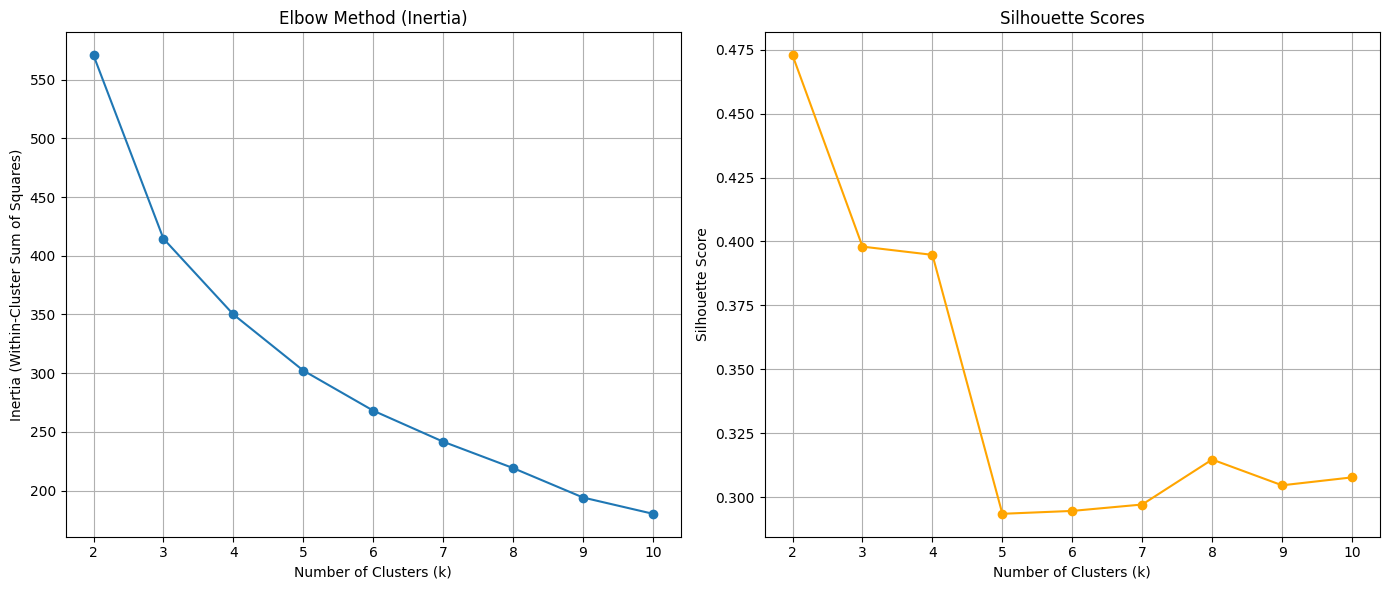

In [13]:
#Determine the ideal number of clusters using the elbow method and the silhouette coefficient
#Visualizing the results of the elbow method

# Elbow Method/Silhouette Coefficient Analysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Range of k values to try
K_range = range(2, 11)

inertia_list = []
silhouette_list = []

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    
    inertia_list.append(kmeans_temp.inertia_)
    
    sil_score = silhouette_score(X_scaled, kmeans_temp.labels_)
    silhouette_list.append(sil_score)

# Plotting the results
plt.figure(figsize=(14, 6))

# 1. Elbow Curve
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia_list, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)

# 2. Silhouette Curve
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_list, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
#Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

# We can see tha that the silhouette score drops sharply after k=4, indicating that the optimal number of clusters is likely around 3 or 4.
k_final = 4

# Retraining KMeans
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Assigning the new cluster labels back to the original dataframe
df['Cluster'] = kmeans_final.labels_

# 3D Visualization with final model
import plotly.express as px

fig = px.scatter_3d(
    df,
    x='3P',
    y='AST',
    z='FG',
    color=df['Cluster'].astype(str),
    title=f'NBA Players Clustering (Final Model with k={k_final})',
    labels={'3P','AST', 'FG'}
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()



In [17]:
#Once again evaluate the quality of the clustering using total variance explained and silhouette scores

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Step 1: Retrain KMeans with k=4
k_final = 4
final_kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
final_kmeans.fit(X_scaled)

# Adding the cluster labels back to your original df
df['Cluster'] = final_kmeans.labels_

# Evaluating

# Total Variance Explained
tss = np.sum((X_scaled - np.mean(X_scaled, axis=0))**2)

# Inertia
inertia = final_kmeans.inertia_

bss = tss - inertia

# Variance explained
variance_explained = bss / tss
print(f"Total Variance Explained: {variance_explained:.4f}")

# Silhouette Score
sil_score = silhouette_score(X_scaled, final_kmeans.labels_)
print(f"Silhouette Score: {sil_score:.4f}")


Total Variance Explained: 0.7016
Silhouette Score: 0.3947


In [ ]:
#Use the model to select players for Mr. Rooney to consider

In [18]:
# Step 1: Computing Medians (to use as criteria)
median_salary = df['Salary'].median()
median_3P = df['3P'].median()
median_AST = df['AST'].median()
median_FG = df['FG'].median()

# Step 2: Good Choices (ALL three metrics above median and Salary below median)
good_choices = df[
    (df['Salary'] < median_salary) &
    (df['3P'] > median_3P) &
    (df['AST'] > median_AST) &
    (df['FG'] > median_FG)
]

# Step 3: Bad Choices (ALL three metrics below median and Salary above median)
bad_choices = df[
    (df['Salary'] > median_salary) &
    (df['3P'] < median_3P) &
    (df['AST'] < median_AST) &
    (df['FG'] < median_FG)
]

print("Good Choices for Mr. Rooney")
print(good_choices[['Player', 'Pos', '3P', 'AST', 'FG', 'Salary', 'Cluster']].sort_values(by='Salary'))

print("\nBad Choices for Mr. Rooney")
print(bad_choices[['Player', 'Pos', '3P', 'AST', 'FG', 'Salary', 'Cluster']].sort_values(by='Salary'))


Good Choices for Mr. Rooney
                       Player    Pos   3P  AST   FG     Salary  Cluster
28               Desmond Bane     SG  3.0  2.7  6.7  2130240.0        1
395         Immanuel Quickley     PG  1.8  3.5  3.6  2316240.0        1
314              Tyrese Maxey     PG  1.8  4.3  6.4  2726880.0        3
42                 Saddiq Bey     SF  2.6  2.8  5.5  2959080.0        1
383          Kevin Porter Jr.     PG  2.5  6.2  5.5  3217631.0        3
13               Cole Anthony     PG  2.0  5.7  5.5  3613680.0        3
244            Keldon Johnson     SF  2.1  2.1  6.3  3873025.0        1
382              Jordan Poole     SG  2.8  4.0  6.2  3901399.0        3
124              Chris Duarte     SG  1.7  2.1  4.9  3936960.0        1
178         Tyrese Haliburton  SG-PG  2.1  8.2  5.6  4215120.0        3
467             Devin Vassell     SF  1.9  1.9  4.6  4437000.0        1
335           Davion Mitchell     PG  1.3  4.2  4.7  4833600.0        0
4    Nickeil Alexander-Walker     SG

In [19]:
# Pick how many unique players to display from each group

num_players_to_display = 5

# Top 5 Good Choices (lowest salary)
top_good_choices = good_choices.sort_values(by='Salary').head(num_players_to_display)

# Top 5 Bad Choices (highest salary)
top_bad_choices = bad_choices.sort_values(by='Salary', ascending=False).head(num_players_to_display)

print(f"Top {num_players_to_display} Good Choices:")
print(top_good_choices[['Player', 'Pos', '3P', 'AST', 'FG', 'Salary', 'Cluster']])

print(f"\nTop {num_players_to_display} Bad Choices:")
print(top_bad_choices[['Player', 'Pos', '3P', 'AST', 'FG', 'Salary', 'Cluster']])


Top 5 Good Choices:
                Player Pos   3P  AST   FG     Salary  Cluster
28        Desmond Bane  SG  3.0  2.7  6.7  2130240.0        1
395  Immanuel Quickley  PG  1.8  3.5  3.6  2316240.0        1
314       Tyrese Maxey  PG  1.8  4.3  6.4  2726880.0        3
42          Saddiq Bey  SF  2.6  2.8  5.5  2959080.0        1
383   Kevin Porter Jr.  PG  2.5  6.2  5.5  3217631.0        3

Top 5 Bad Choices:
             Player Pos   3P  AST   FG        Salary  Cluster
132  Derrick Favors   C  0.1  0.6  2.4  1.018380e+07        2
170  JaMychal Green  PF  0.5  0.9  2.4  1.003609e+07        2
255  DeAndre Jordan   C  0.0  0.4  1.9  9.663997e+06        2
472   Ish Wainright  PF  0.4  0.3  0.9  9.270959e+06        2
360    Nerlens Noel   C  0.0  0.9  1.3  9.240000e+06        2


#Write up the results in a separate notebook with supporting visualizations and 
an overview of how and why you made the choices you did. This should be at least 
500 words and should be written for a non-technical audience.